# About this notebook  

TBD...

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True

# Data Loading

In [2]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
os.listdir("../input/cassava-leaf-disease-classification")

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'test_images',
 'test_tfrecords',
 'train.csv',
 'train_images',
 'train_tfrecords']

In [4]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/home/sugi/kernel/kaggle/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

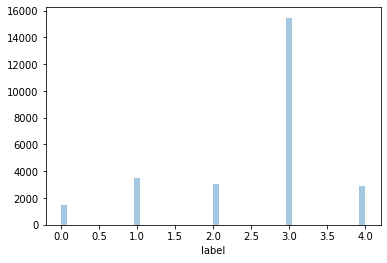

In [5]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = (
        "tf_efficientnet_b4_ns"  # resnext50_32x4d, tf_efficientnet_b3_ns, tf_efficientnet_b4_ns, vit_base_patch16_384
    )
    batch_size = 16  # resnext50_32x4d: 14-30, tf_efficientnet_b3_ns:10-22, tf_efficientnet_b4_ns: 8-16
    gradient_accumulation_steps = 2
    size = 384 if model_name.startswith("vit_base_") else 512  # 512 if ON_KAGGLE else 384
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.05
    scheduler = "CosineAnnealingWarmupRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs
    )  # CosineAnnealingWarmRestarts
    first_cycle_steps = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs
    )  # CosineAnnealingWarmupRestarts for batch update
    warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 2e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 1012
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [10]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [11]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

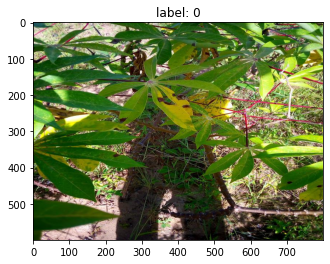

In [12]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

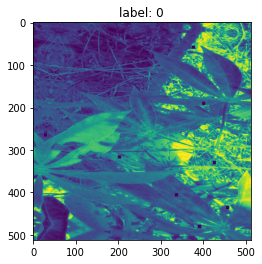

In [14]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [15]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    # mask =torch.tensor(mask, device=device).float()
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MixUp

In [16]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, y_b, lam)

# MODEL

In [17]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if model_name == "resnext50_32x4d":
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG.target_size)

        elif model_name.startswith("tf_efficientnet"):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.target_size)

        elif model_name.startswith("vit_base_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    elif CFG.model_name.startswith("resnext50_32x4d") and False:
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2}: {type(child2)} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                if isinstance(child2, nn.modules.container.Sequential):
                    for child3 in child2.children():
                        for child4 in child3.children():
                            if isinstance(child4, nn.BatchNorm2d):
                                # print(child4)
                                for param in child4.parameters():
                                    param.requires_grad = False
                                    # print(param.requires_grad)

In [19]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.5260, -0.1773,  0.1458, -0.3601,  0.0811],
        [ 0.0922, -0.0564,  0.0365,  0.0019,  0.0436],
        [ 0.0588, -0.0615,  0.0335, -0.0242,  0.0124],
        [ 0.0473, -0.0625,  0.0377, -0.0339,  0.0162]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [20]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        if epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, labels, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [22]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda"):
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [23]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [ ]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/1316] Elapsed 0m 3s (remain 83m 48s) Loss: 0.5078(0.5078) Grad: 0.3334 LR: 0.000002  
Epoch: [1][100/1316] Elapsed 2m 28s (remain 29m 43s) Loss: 0.4780(0.4960) Grad: 0.4040 LR: 0.000017  
Epoch: [1][200/1316] Elapsed 4m 52s (remain 27m 2s) Loss: 0.3333(0.4655) Grad: 0.4492 LR: 0.000032  
Epoch: [1][300/1316] Elapsed 7m 16s (remain 24m 32s) Loss: 0.4054(0.4256) Grad: 0.2944 LR: 0.000047  
Epoch: [1][400/1316] Elapsed 9m 40s (remain 22m 5s) Loss: 0.2499(0.3949) Grad: 0.2797 LR: 0.000062  
Epoch: [1][500/1316] Elapsed 12m 4s (remain 19m 38s) Loss: 0.2174(0.3782) Grad: 0.3270 LR: 0.000077  
Epoch: [1][600/1316] Elapsed 14m 28s (remain 17m 13s) Loss: 0.2990(0.3599) Grad: 0.2308 LR: 0.000092  
Epoch: [1][700/1316] Elapsed 16m 53s (remain 14m 48s) Loss: 0.3944(0.3459) Grad: 0.5332 LR: 0.000107  
Epoch: [1][800/1316] Elapsed 19m 17s (remain 12m 24s) Loss: 0.3669(0.3347) Grad: 0.5300 LR: 0.000122  
Epoch: [1][900/1316] Elapsed 21m 41s (remain 9m 59s) Loss: 0.1211(0.3231) Grad: 0.39

Epoch 1 - avg_train_loss: 0.2985  avg_val_loss: 0.1412  time: 2045s
Epoch 1 - Accuracy: 0.8502277904328018
Epoch 1 - Save Best Score: 0.8502 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.1630(0.1412) 
Epoch: [2][0/1316] Elapsed 0m 2s (remain 44m 1s) Loss: 0.1247(0.1247) Grad: 0.3350 LR: 0.000200  
Epoch: [2][100/1316] Elapsed 2m 26s (remain 29m 20s) Loss: 0.1884(0.2358) Grad: 0.2092 LR: 0.000200  
Epoch: [2][200/1316] Elapsed 4m 51s (remain 26m 54s) Loss: 0.1396(0.2337) Grad: 0.4776 LR: 0.000200  
Epoch: [2][300/1316] Elapsed 7m 15s (remain 24m 28s) Loss: 0.1761(0.2345) Grad: 0.3454 LR: 0.000200  
Epoch: [2][400/1316] Elapsed 9m 39s (remain 22m 2s) Loss: 0.1286(0.2342) Grad: 0.3227 LR: 0.000199  
Epoch: [2][500/1316] Elapsed 12m 3s (remain 19m 37s) Loss: 0.2853(0.2329) Grad: 0.1954 LR: 0.000199  
Epoch: [2][600/1316] Elapsed 14m 28s (remain 17m 13s) Loss: 0.0677(0.2300) Grad: 0.2981 LR: 0.000199  
Epoch: [2][700/1316] Elapsed 16m 52s (remain 14m 48s) Loss: 0.1518(0.2300) Grad: 0.3387 LR: 0.000198  
Epoch: [2][800/1316] Elapsed 19m 16s (remain 12m 23s) Loss: 0.1256(0.2301) Grad: 0.2736 LR: 0.000198  
Epoch: [2][900/1

Epoch 2 - avg_train_loss: 0.2257  avg_val_loss: 0.1187  time: 2044s
Epoch 2 - Accuracy: 0.8756643887623387
Epoch 2 - Save Best Score: 0.8757 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0899(0.1187) 
Epoch: [3][0/1316] Elapsed 0m 2s (remain 45m 31s) Loss: 0.3166(0.3166) Grad: 0.5707 LR: 0.000194  
Epoch: [3][100/1316] Elapsed 2m 26s (remain 29m 21s) Loss: 0.2492(0.2001) Grad: 0.3323 LR: 0.000193  
Epoch: [3][200/1316] Elapsed 4m 50s (remain 26m 52s) Loss: 0.2619(0.2072) Grad: 0.1830 LR: 0.000192  
Epoch: [3][300/1316] Elapsed 7m 14s (remain 24m 25s) Loss: 0.2246(0.2113) Grad: 0.3494 LR: 0.000191  
Epoch: [3][400/1316] Elapsed 9m 38s (remain 21m 59s) Loss: 0.2596(0.2109) Grad: 0.2908 LR: 0.000190  
Epoch: [3][500/1316] Elapsed 12m 2s (remain 19m 35s) Loss: 0.2783(0.2115) Grad: 0.3941 LR: 0.000189  
Epoch: [3][600/1316] Elapsed 14m 27s (remain 17m 11s) Loss: 0.2106(0.2131) Grad: 0.2924 LR: 0.000187  
Epoch: [3][700/1316] Elapsed 16m 50s (remain 14m 46s) Loss: 0.2399(0.2119) Grad: 0.2279 LR: 0.000186  
Epoch: [3][800/1316] Elapsed 19m 15s (remain 12m 23s) Loss: 0.2763(0.2123) Grad: 0.3058 LR: 0.000185  
Epoch: [3][900

Epoch 3 - avg_train_loss: 0.2116  avg_val_loss: 0.1167  time: 2044s
Epoch 3 - Accuracy: 0.8830675778283978
Epoch 3 - Save Best Score: 0.8831 Model


EVAL: [329/330] Elapsed 2m 24s (remain 0m 0s) Loss: 0.0542(0.1167) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 43m 10s) Loss: 0.3368(0.3368) Grad: 0.3641 LR: 0.000177  
Epoch: [4][100/1316] Elapsed 2m 25s (remain 29m 14s) Loss: 0.1186(0.1924) Grad: 0.2822 LR: 0.000175  
Epoch: [4][200/1316] Elapsed 4m 49s (remain 26m 46s) Loss: 0.2903(0.1960) Grad: 0.2321 LR: 0.000173  
Epoch: [4][300/1316] Elapsed 7m 13s (remain 24m 21s) Loss: 0.2660(0.1968) Grad: 0.1596 LR: 0.000172  
Epoch: [4][400/1316] Elapsed 9m 37s (remain 21m 57s) Loss: 0.0687(0.1987) Grad: 0.2893 LR: 0.000170  
Epoch: [4][500/1316] Elapsed 12m 2s (remain 19m 34s) Loss: 0.2002(0.2021) Grad: 0.3240 LR: 0.000168  
Epoch: [4][600/1316] Elapsed 14m 27s (remain 17m 11s) Loss: 0.2628(0.2038) Grad: 0.2281 LR: 0.000166  
Epoch: [4][700/1316] Elapsed 16m 51s (remain 14m 46s) Loss: 0.1411(0.2026) Grad: 0.2700 LR: 0.000164  
Epoch: [4][800/1316] Elapsed 19m 15s (remain 12m 22s) Loss: 0.2182(0.2037) Grad: 0.3373 LR: 0.000162  
Epoch: [4][900

Epoch 4 - avg_train_loss: 0.2028  avg_val_loss: 0.1149  time: 2041s
Epoch 4 - Accuracy: 0.8735763097949886


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0613(0.1149) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 43m 19s) Loss: 0.1754(0.1754) Grad: 0.1849 LR: 0.000150  
Epoch: [5][100/1316] Elapsed 2m 26s (remain 29m 26s) Loss: 0.2259(0.2118) Grad: 0.1895 LR: 0.000148  
Epoch: [5][200/1316] Elapsed 4m 51s (remain 26m 55s) Loss: 0.1647(0.2038) Grad: 0.1460 LR: 0.000146  
Epoch: [5][300/1316] Elapsed 7m 15s (remain 24m 27s) Loss: 0.1971(0.2030) Grad: 0.1362 LR: 0.000144  
Epoch: [5][400/1316] Elapsed 9m 39s (remain 22m 1s) Loss: 0.2354(0.2020) Grad: 0.2033 LR: 0.000141  
Epoch: [5][500/1316] Elapsed 12m 4s (remain 19m 37s) Loss: 0.2012(0.1991) Grad: 0.3553 LR: 0.000139  
Epoch: [5][600/1316] Elapsed 14m 28s (remain 17m 13s) Loss: 0.1145(0.1981) Grad: 0.2724 LR: 0.000136  
Epoch: [5][700/1316] Elapsed 16m 52s (remain 14m 48s) Loss: 0.1448(0.1985) Grad: 0.1335 LR: 0.000134  
Epoch: [5][800/1316] Elapsed 19m 17s (remain 12m 24s) Loss: 0.2118(0.1982) Grad: 0.3203 LR: 0.000131  
Epoch: [5][900/

Epoch 5 - avg_train_loss: 0.1976  avg_val_loss: 0.1097  time: 2047s
Epoch 5 - Accuracy: 0.8823082763857252


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.1586(0.1097) 
Epoch: [6][0/1316] Elapsed 0m 2s (remain 44m 31s) Loss: 0.2607(0.2607) Grad: 0.2365 LR: 0.000118  
Epoch: [6][100/1316] Elapsed 2m 26s (remain 29m 23s) Loss: 0.1988(0.2051) Grad: 0.2817 LR: 0.000116  
Epoch: [6][200/1316] Elapsed 4m 50s (remain 26m 53s) Loss: 0.0943(0.1986) Grad: 0.2747 LR: 0.000113  
Epoch: [6][300/1316] Elapsed 7m 15s (remain 24m 29s) Loss: 0.1262(0.1968) Grad: 0.3630 LR: 0.000110  
Epoch: [6][400/1316] Elapsed 9m 40s (remain 22m 3s) Loss: 0.0572(0.1976) Grad: 0.2399 LR: 0.000108  
Epoch: [6][500/1316] Elapsed 12m 4s (remain 19m 38s) Loss: 0.0543(0.1960) Grad: 0.2421 LR: 0.000105  
Epoch: [6][600/1316] Elapsed 14m 29s (remain 17m 13s) Loss: 0.2096(0.1952) Grad: 0.2004 LR: 0.000103  
Epoch: [6][700/1316] Elapsed 16m 53s (remain 14m 49s) Loss: 0.2871(0.1972) Grad: 0.1998 LR: 0.000100  
Epoch: [6][800/1316] Elapsed 19m 17s (remain 12m 24s) Loss: 0.2425(0.1983) Grad: 0.1555 LR: 0.000097  
Epoch: [6][900/

Epoch 6 - avg_train_loss: 0.1955  avg_val_loss: 0.1091  time: 2046s
Epoch 6 - Accuracy: 0.8847760060744115
Epoch 6 - Save Best Score: 0.8848 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.1199(0.1091) 
Epoch: [7][0/1316] Elapsed 0m 2s (remain 43m 58s) Loss: 0.2984(0.2984) Grad: 0.3201 LR: 0.000084  
Epoch: [7][100/1316] Elapsed 2m 26s (remain 29m 21s) Loss: 0.0649(0.1666) Grad: 0.3638 LR: 0.000081  
Epoch: [7][200/1316] Elapsed 4m 49s (remain 26m 47s) Loss: 0.1551(0.1533) Grad: 0.1605 LR: 0.000079  
Epoch: [7][300/1316] Elapsed 7m 13s (remain 24m 22s) Loss: 0.2539(0.1533) Grad: 0.2516 LR: 0.000076  
Epoch: [7][400/1316] Elapsed 9m 37s (remain 21m 58s) Loss: 0.1592(0.1501) Grad: 0.2745 LR: 0.000074  
Epoch: [7][500/1316] Elapsed 12m 1s (remain 19m 32s) Loss: 0.0176(0.1502) Grad: 0.1529 LR: 0.000071  
Epoch: [7][600/1316] Elapsed 14m 25s (remain 17m 9s) Loss: 0.1033(0.1502) Grad: 0.2996 LR: 0.000069  
Epoch: [7][700/1316] Elapsed 16m 49s (remain 14m 45s) Loss: 0.1128(0.1517) Grad: 0.2751 LR: 0.000066  
Epoch: [7][800/1316] Elapsed 19m 12s (remain 12m 21s) Loss: 0.1830(0.1512) Grad: 0.4248 LR: 0.000064  
Epoch: [7][900/

Epoch 7 - avg_train_loss: 0.1498  avg_val_loss: 0.1038  time: 2037s
Epoch 7 - Accuracy: 0.8845861807137434


EVAL: [329/330] Elapsed 2m 22s (remain 0m 0s) Loss: 0.1246(0.1038) 
Epoch: [8][0/1316] Elapsed 0m 2s (remain 44m 7s) Loss: 0.0641(0.0641) Grad: 0.3076 LR: 0.000052  
Epoch: [8][100/1316] Elapsed 2m 25s (remain 29m 11s) Loss: 0.0780(0.1267) Grad: 0.4824 LR: 0.000049  
Epoch: [8][200/1316] Elapsed 4m 49s (remain 26m 43s) Loss: 0.1860(0.1375) Grad: 0.2856 LR: 0.000047  
Epoch: [8][300/1316] Elapsed 7m 12s (remain 24m 18s) Loss: 0.0999(0.1412) Grad: 0.3575 LR: 0.000045  
Epoch: [8][400/1316] Elapsed 9m 36s (remain 21m 55s) Loss: 0.2717(0.1415) Grad: 0.1981 LR: 0.000043  
Epoch: [8][500/1316] Elapsed 11m 59s (remain 19m 31s) Loss: 0.0594(0.1392) Grad: 0.2789 LR: 0.000041  
Epoch: [8][600/1316] Elapsed 14m 23s (remain 17m 7s) Loss: 0.1461(0.1403) Grad: 0.5586 LR: 0.000039  
Epoch: [8][700/1316] Elapsed 16m 47s (remain 14m 44s) Loss: 0.0207(0.1418) Grad: 0.2260 LR: 0.000037  
Epoch: [8][800/1316] Elapsed 19m 11s (remain 12m 20s) Loss: 0.0727(0.1416) Grad: 0.2929 LR: 0.000035  
Epoch: [8][900/

Epoch 8 - avg_train_loss: 0.1385  avg_val_loss: 0.1028  time: 2036s
Epoch 8 - Accuracy: 0.8883826879271071
Epoch 8 - Save Best Score: 0.8884 Model


EVAL: [329/330] Elapsed 2m 22s (remain 0m 0s) Loss: 0.1132(0.1028) 
Epoch: [9][0/1316] Elapsed 0m 2s (remain 45m 8s) Loss: 0.0984(0.0984) Grad: 0.1639 LR: 0.000025  
Epoch: [9][100/1316] Elapsed 2m 26s (remain 29m 20s) Loss: 0.1118(0.1300) Grad: 0.1970 LR: 0.000024  
Epoch: [9][200/1316] Elapsed 4m 50s (remain 26m 49s) Loss: 0.0214(0.1368) Grad: 0.1752 LR: 0.000022  
Epoch: [9][300/1316] Elapsed 7m 13s (remain 24m 23s) Loss: 0.0467(0.1388) Grad: 0.2460 LR: 0.000020  
Epoch: [9][400/1316] Elapsed 9m 38s (remain 21m 59s) Loss: 0.1888(0.1389) Grad: 0.1783 LR: 0.000019  
Epoch: [9][500/1316] Elapsed 12m 2s (remain 19m 35s) Loss: 0.1540(0.1402) Grad: 0.1534 LR: 0.000017  
Epoch: [9][600/1316] Elapsed 14m 26s (remain 17m 11s) Loss: 0.2797(0.1392) Grad: 0.2494 LR: 0.000016  
Epoch: [9][700/1316] Elapsed 16m 51s (remain 14m 47s) Loss: 0.1085(0.1400) Grad: 0.1793 LR: 0.000015  
Epoch: [9][800/1316] Elapsed 19m 15s (remain 12m 22s) Loss: 0.0418(0.1370) Grad: 0.3859 LR: 0.000013  
Epoch: [9][900/

Epoch 9 - avg_train_loss: 0.1361  avg_val_loss: 0.1024  time: 2039s
Epoch 9 - Accuracy: 0.8874335611237661


EVAL: [329/330] Elapsed 2m 22s (remain 0m 0s) Loss: 0.1013(0.1024) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 41m 34s) Loss: 0.2599(0.2599) Grad: 0.3291 LR: 0.000008  
Epoch: [10][100/1316] Elapsed 2m 25s (remain 29m 6s) Loss: 0.0466(0.0903) Grad: 0.4049 LR: 0.000007  
Epoch: [10][200/1316] Elapsed 4m 48s (remain 26m 40s) Loss: 0.0611(0.0888) Grad: 0.3873 LR: 0.000006  
Epoch: [10][300/1316] Elapsed 7m 11s (remain 24m 15s) Loss: 0.1399(0.0850) Grad: 0.4458 LR: 0.000006  
Epoch: [10][400/1316] Elapsed 9m 35s (remain 21m 52s) Loss: 0.0956(0.0848) Grad: 0.3739 LR: 0.000005  
Epoch: [10][500/1316] Elapsed 11m 58s (remain 19m 28s) Loss: 0.0544(0.0866) Grad: 0.3409 LR: 0.000004  
Epoch: [10][600/1316] Elapsed 14m 21s (remain 17m 4s) Loss: 0.0055(0.0867) Grad: 0.0546 LR: 0.000004  
Epoch: [10][700/1316] Elapsed 16m 45s (remain 14m 41s) Loss: 0.1339(0.0857) Grad: 0.4824 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 19m 8s (remain 12m 18s) Loss: 0.0364(0.0857) Grad: 0.2654 LR: 0.000003  
Epoch: 

Epoch 10 - avg_train_loss: 0.0862  avg_val_loss: 0.1013  time: 2030s
Epoch 10 - Accuracy: 0.8872437357630979
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0949(0.1013) 


========== fold: 0 result ==========
Score: 0.88838
========== fold: 1 training ==========


Epoch: [1][0/1316] Elapsed 0m 2s (remain 45m 33s) Loss: 0.5046(0.5046) Grad: 0.3606 LR: 0.000002  
Epoch: [1][100/1316] Elapsed 2m 26s (remain 29m 24s) Loss: 0.4807(0.4906) Grad: 0.3141 LR: 0.000017  
Epoch: [1][200/1316] Elapsed 4m 51s (remain 26m 58s) Loss: 0.3937(0.4625) Grad: 0.3215 LR: 0.000032  
Epoch: [1][300/1316] Elapsed 7m 16s (remain 24m 32s) Loss: 0.2476(0.4208) Grad: 0.3226 LR: 0.000047  
Epoch: [1][400/1316] Elapsed 9m 41s (remain 22m 7s) Loss: 0.2104(0.3943) Grad: 0.3066 LR: 0.000062  
Epoch: [1][500/1316] Elapsed 12m 6s (remain 19m 42s) Loss: 0.3011(0.3698) Grad: 0.2978 LR: 0.000077  
Epoch: [1][600/1316] Elapsed 14m 31s (remain 17m 17s) Loss: 0.1958(0.3546) Grad: 0.3508 LR: 0.000092  
Epoch: [1][700/1316] Elapsed 16m 56s (remain 14m 51s) Loss: 0.1339(0.3413) Grad: 0.3169 LR: 0.000107  
Epoch: [1][800/1316] Elapsed 19m 21s (remain 12m 26s) Loss: 0.2575(0.3287) Grad: 0.3301 LR: 0.000122  
Epoch: [1][900/1316] Elapsed 21m 45s (remain 10m 1s) Loss: 0.3015(0.3201) Grad: 0.3

Epoch 1 - avg_train_loss: 0.2958  avg_val_loss: 0.1276  time: 2048s
Epoch 1 - Accuracy: 0.8654138192862566
Epoch 1 - Save Best Score: 0.8654 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0108(0.1276) 
Epoch: [2][0/1316] Elapsed 0m 2s (remain 45m 19s) Loss: 0.2585(0.2585) Grad: 0.2584 LR: 0.000200  
Epoch: [2][100/1316] Elapsed 2m 26s (remain 29m 22s) Loss: 0.2141(0.2250) Grad: 0.3860 LR: 0.000200  
Epoch: [2][200/1316] Elapsed 4m 50s (remain 26m 53s) Loss: 0.1816(0.2228) Grad: 0.2245 LR: 0.000200  
Epoch: [2][300/1316] Elapsed 7m 15s (remain 24m 28s) Loss: 0.2887(0.2238) Grad: 0.3175 LR: 0.000200  
Epoch: [2][400/1316] Elapsed 9m 39s (remain 22m 3s) Loss: 0.2410(0.2264) Grad: 0.2581 LR: 0.000199  
Epoch: [2][500/1316] Elapsed 12m 4s (remain 19m 38s) Loss: 0.1825(0.2285) Grad: 0.4428 LR: 0.000199  
Epoch: [2][600/1316] Elapsed 14m 29s (remain 17m 14s) Loss: 0.1707(0.2272) Grad: 0.3381 LR: 0.000199  
Epoch: [2][700/1316] Elapsed 16m 53s (remain 14m 49s) Loss: 0.2429(0.2248) Grad: 0.5052 LR: 0.000198  
Epoch: [2][800/1316] Elapsed 19m 17s (remain 12m 24s) Loss: 0.3023(0.2238) Grad: 0.1503 LR: 0.000198  
Epoch: [2][900/

Epoch 2 - avg_train_loss: 0.2220  avg_val_loss: 0.1117  time: 2045s
Epoch 2 - Accuracy: 0.8815489749430524
Epoch 2 - Save Best Score: 0.8815 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0049(0.1117) 
Epoch: [3][0/1316] Elapsed 0m 2s (remain 44m 35s) Loss: 0.2378(0.2378) Grad: 0.1736 LR: 0.000194  
Epoch: [3][100/1316] Elapsed 2m 26s (remain 29m 23s) Loss: 0.3041(0.2117) Grad: 0.2196 LR: 0.000193  
Epoch: [3][200/1316] Elapsed 4m 51s (remain 26m 57s) Loss: 0.0750(0.2149) Grad: 0.2696 LR: 0.000192  
Epoch: [3][300/1316] Elapsed 7m 16s (remain 24m 33s) Loss: 0.3365(0.2157) Grad: 0.3152 LR: 0.000191  
Epoch: [3][400/1316] Elapsed 9m 42s (remain 22m 8s) Loss: 0.1446(0.2165) Grad: 0.2140 LR: 0.000190  
Epoch: [3][500/1316] Elapsed 12m 6s (remain 19m 42s) Loss: 0.2519(0.2171) Grad: 0.1903 LR: 0.000189  
Epoch: [3][600/1316] Elapsed 14m 31s (remain 17m 16s) Loss: 0.2835(0.2178) Grad: 0.3019 LR: 0.000187  
Epoch: [3][700/1316] Elapsed 16m 55s (remain 14m 51s) Loss: 0.0491(0.2150) Grad: 0.1972 LR: 0.000186  
Epoch: [3][800/1316] Elapsed 19m 20s (remain 12m 25s) Loss: 0.2392(0.2132) Grad: 0.3601 LR: 0.000185  
Epoch: [3][900/

Epoch 3 - avg_train_loss: 0.2116  avg_val_loss: 0.1075  time: 2049s
Epoch 3 - Accuracy: 0.8826879271070615
Epoch 3 - Save Best Score: 0.8827 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0078(0.1075) 
Epoch: [4][0/1316] Elapsed 0m 2s (remain 44m 15s) Loss: 0.1837(0.1837) Grad: 0.2434 LR: 0.000177  
Epoch: [4][100/1316] Elapsed 2m 26s (remain 29m 18s) Loss: 0.2038(0.1992) Grad: 0.2790 LR: 0.000175  
Epoch: [4][200/1316] Elapsed 4m 51s (remain 26m 54s) Loss: 0.0580(0.2031) Grad: 0.2417 LR: 0.000173  
Epoch: [4][300/1316] Elapsed 7m 15s (remain 24m 27s) Loss: 0.3342(0.2023) Grad: 0.3365 LR: 0.000172  
Epoch: [4][400/1316] Elapsed 9m 39s (remain 22m 2s) Loss: 0.1086(0.2036) Grad: 0.3790 LR: 0.000170  
Epoch: [4][500/1316] Elapsed 12m 4s (remain 19m 38s) Loss: 0.1342(0.2041) Grad: 0.2054 LR: 0.000168  
Epoch: [4][600/1316] Elapsed 14m 28s (remain 17m 13s) Loss: 0.1063(0.2064) Grad: 0.3190 LR: 0.000166  
Epoch: [4][700/1316] Elapsed 16m 52s (remain 14m 48s) Loss: 0.1462(0.2066) Grad: 0.3033 LR: 0.000164  
Epoch: [4][800/1316] Elapsed 19m 17s (remain 12m 23s) Loss: 0.1518(0.2071) Grad: 0.4441 LR: 0.000162  
Epoch: [4][900/

Epoch 4 - avg_train_loss: 0.2046  avg_val_loss: 0.1104  time: 2045s
Epoch 4 - Accuracy: 0.8864844343204252
Epoch 4 - Save Best Score: 0.8865 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0121(0.1104) 
Epoch: [5][0/1316] Elapsed 0m 2s (remain 45m 32s) Loss: 0.2446(0.2446) Grad: 0.2812 LR: 0.000150  
Epoch: [5][100/1316] Elapsed 2m 26s (remain 29m 20s) Loss: 0.2885(0.2101) Grad: 0.2401 LR: 0.000148  
Epoch: [5][200/1316] Elapsed 4m 50s (remain 26m 53s) Loss: 0.0561(0.2053) Grad: 0.3034 LR: 0.000146  
Epoch: [5][300/1316] Elapsed 7m 15s (remain 24m 28s) Loss: 0.1072(0.2030) Grad: 0.3703 LR: 0.000144  
Epoch: [5][400/1316] Elapsed 9m 39s (remain 22m 2s) Loss: 0.2561(0.2022) Grad: 0.2376 LR: 0.000141  
Epoch: [5][500/1316] Elapsed 12m 3s (remain 19m 37s) Loss: 0.3821(0.1999) Grad: 0.2358 LR: 0.000139  
Epoch: [5][600/1316] Elapsed 14m 28s (remain 17m 12s) Loss: 0.0551(0.2003) Grad: 0.2856 LR: 0.000136  
Epoch: [5][700/1316] Elapsed 16m 52s (remain 14m 48s) Loss: 0.1207(0.1974) Grad: 0.4199 LR: 0.000134  
Epoch: [5][800/1316] Elapsed 19m 16s (remain 12m 23s) Loss: 0.0998(0.1973) Grad: 0.3549 LR: 0.000131  
Epoch: [5][900/

Epoch 5 - avg_train_loss: 0.1989  avg_val_loss: 0.1037  time: 2046s
Epoch 5 - Accuracy: 0.8864844343204252


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0099(0.1037) 
Epoch: [6][0/1316] Elapsed 0m 2s (remain 45m 33s) Loss: 0.1649(0.1649) Grad: 0.3607 LR: 0.000118  
Epoch: [6][100/1316] Elapsed 2m 26s (remain 29m 23s) Loss: 0.3149(0.2056) Grad: 0.3466 LR: 0.000116  
Epoch: [6][200/1316] Elapsed 4m 51s (remain 26m 55s) Loss: 0.1636(0.1991) Grad: 0.1697 LR: 0.000113  
Epoch: [6][300/1316] Elapsed 7m 15s (remain 24m 29s) Loss: 0.2133(0.1938) Grad: 0.4067 LR: 0.000110  
Epoch: [6][400/1316] Elapsed 9m 40s (remain 22m 3s) Loss: 0.0266(0.1925) Grad: 0.1528 LR: 0.000108  
Epoch: [6][500/1316] Elapsed 12m 4s (remain 19m 38s) Loss: 0.0828(0.1938) Grad: 0.3640 LR: 0.000105  
Epoch: [6][600/1316] Elapsed 14m 28s (remain 17m 13s) Loss: 0.1876(0.1929) Grad: 0.3908 LR: 0.000103  
Epoch: [6][700/1316] Elapsed 16m 52s (remain 14m 48s) Loss: 0.2649(0.1901) Grad: 0.1431 LR: 0.000100  
Epoch: [6][800/1316] Elapsed 19m 17s (remain 12m 24s) Loss: 0.1622(0.1913) Grad: 0.3411 LR: 0.000097  
Epoch: [6][900/

Epoch 6 - avg_train_loss: 0.1902  avg_val_loss: 0.0987  time: 2046s
Epoch 6 - Accuracy: 0.892369020501139
Epoch 6 - Save Best Score: 0.8924 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0033(0.0987) 
Epoch: [7][0/1316] Elapsed 0m 2s (remain 44m 6s) Loss: 0.0697(0.0697) Grad: 0.3365 LR: 0.000084  
Epoch: [7][100/1316] Elapsed 2m 25s (remain 29m 16s) Loss: 0.0476(0.1511) Grad: 0.3177 LR: 0.000081  
Epoch: [7][200/1316] Elapsed 4m 49s (remain 26m 45s) Loss: 0.1036(0.1462) Grad: 0.2682 LR: 0.000079  
Epoch: [7][300/1316] Elapsed 7m 13s (remain 24m 23s) Loss: 0.0703(0.1473) Grad: 0.3816 LR: 0.000076  
Epoch: [7][400/1316] Elapsed 9m 38s (remain 21m 59s) Loss: 0.2873(0.1481) Grad: 0.1873 LR: 0.000074  
Epoch: [7][500/1316] Elapsed 12m 2s (remain 19m 34s) Loss: 0.1445(0.1477) Grad: 0.0870 LR: 0.000071  
Epoch: [7][600/1316] Elapsed 14m 26s (remain 17m 10s) Loss: 0.0414(0.1490) Grad: 0.2626 LR: 0.000069  
Epoch: [7][700/1316] Elapsed 16m 50s (remain 14m 46s) Loss: 0.3640(0.1504) Grad: 0.3500 LR: 0.000066  
Epoch: [7][800/1316] Elapsed 19m 14s (remain 12m 21s) Loss: 0.1291(0.1488) Grad: 0.3479 LR: 0.000064  
Epoch: [7][900/

Epoch 7 - avg_train_loss: 0.1501  avg_val_loss: 0.0967  time: 2040s
Epoch 7 - Accuracy: 0.8948367501898253
Epoch 7 - Save Best Score: 0.8948 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0028(0.0967) 
Epoch: [8][0/1316] Elapsed 0m 2s (remain 45m 15s) Loss: 0.0901(0.0901) Grad: 0.3271 LR: 0.000052  
Epoch: [8][100/1316] Elapsed 2m 27s (remain 29m 28s) Loss: 0.0609(0.1468) Grad: 0.2780 LR: 0.000049  
Epoch: [8][200/1316] Elapsed 4m 50s (remain 26m 53s) Loss: 0.1134(0.1472) Grad: 0.2595 LR: 0.000047  
Epoch: [8][300/1316] Elapsed 7m 14s (remain 24m 26s) Loss: 0.1046(0.1484) Grad: 0.3001 LR: 0.000045  
Epoch: [8][400/1316] Elapsed 9m 39s (remain 22m 1s) Loss: 0.0468(0.1505) Grad: 0.3422 LR: 0.000043  
Epoch: [8][500/1316] Elapsed 12m 3s (remain 19m 36s) Loss: 0.0678(0.1463) Grad: 0.1923 LR: 0.000041  
Epoch: [8][600/1316] Elapsed 14m 27s (remain 17m 11s) Loss: 0.3089(0.1472) Grad: 0.2899 LR: 0.000039  
Epoch: [8][700/1316] Elapsed 16m 51s (remain 14m 47s) Loss: 0.1855(0.1470) Grad: 0.1627 LR: 0.000037  
Epoch: [8][800/1316] Elapsed 19m 14s (remain 12m 22s) Loss: 0.0686(0.1452) Grad: 0.3634 LR: 0.000035  
Epoch: [8][900/

Epoch 8 - avg_train_loss: 0.1451  avg_val_loss: 0.0960  time: 2039s
Epoch 8 - Accuracy: 0.8950265755504936
Epoch 8 - Save Best Score: 0.8950 Model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0021(0.0960) 
Epoch: [9][0/1316] Elapsed 0m 2s (remain 45m 24s) Loss: 0.1658(0.1658) Grad: 0.3091 LR: 0.000025  
Epoch: [9][100/1316] Elapsed 2m 26s (remain 29m 20s) Loss: 0.1861(0.1471) Grad: 0.4294 LR: 0.000024  
Epoch: [9][200/1316] Elapsed 4m 49s (remain 26m 47s) Loss: 0.3073(0.1457) Grad: 0.2872 LR: 0.000022  
Epoch: [9][300/1316] Elapsed 7m 13s (remain 24m 21s) Loss: 0.1399(0.1437) Grad: 0.2249 LR: 0.000020  
Epoch: [9][400/1316] Elapsed 9m 37s (remain 21m 57s) Loss: 0.0800(0.1438) Grad: 0.1920 LR: 0.000019  
Epoch: [9][500/1316] Elapsed 12m 1s (remain 19m 34s) Loss: 0.0742(0.1436) Grad: 0.1921 LR: 0.000017  
Epoch: [9][600/1316] Elapsed 14m 26s (remain 17m 10s) Loss: 0.0090(0.1445) Grad: 0.0885 LR: 0.000016  
Epoch: [9][700/1316] Elapsed 16m 50s (remain 14m 46s) Loss: 0.1245(0.1419) Grad: 0.3636 LR: 0.000015  
Epoch: [9][800/1316] Elapsed 19m 14s (remain 12m 22s) Loss: 0.0433(0.1431) Grad: 0.3008 LR: 0.000013  
Epoch: [9][900

Epoch 9 - avg_train_loss: 0.1394  avg_val_loss: 0.0975  time: 2039s
Epoch 9 - Accuracy: 0.893507972665148


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0035(0.0975) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 42m 21s) Loss: 0.0752(0.0752) Grad: 0.2573 LR: 0.000008  
Epoch: [10][100/1316] Elapsed 2m 25s (remain 29m 5s) Loss: 0.1587(0.0877) Grad: 0.3558 LR: 0.000007  
Epoch: [10][200/1316] Elapsed 4m 48s (remain 26m 37s) Loss: 0.1546(0.0877) Grad: 0.5418 LR: 0.000006  
Epoch: [10][300/1316] Elapsed 7m 10s (remain 24m 12s) Loss: 0.0578(0.0852) Grad: 0.2706 LR: 0.000006  
Epoch: [10][400/1316] Elapsed 9m 33s (remain 21m 49s) Loss: 0.0619(0.0860) Grad: 0.2143 LR: 0.000005  
Epoch: [10][500/1316] Elapsed 11m 56s (remain 19m 26s) Loss: 0.0335(0.0873) Grad: 0.2452 LR: 0.000004  
Epoch: [10][600/1316] Elapsed 14m 19s (remain 17m 2s) Loss: 0.2379(0.0874) Grad: 0.5274 LR: 0.000004  
Epoch: [10][700/1316] Elapsed 16m 43s (remain 14m 40s) Loss: 0.0133(0.0865) Grad: 0.2011 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 19m 6s (remain 12m 17s) Loss: 0.0978(0.0882) Grad: 0.2620 LR: 0.000003  
Epoch: 

Epoch 10 - avg_train_loss: 0.0878  avg_val_loss: 0.0966  time: 2029s
Epoch 10 - Accuracy: 0.8931283219438116
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 2m 23s (remain 0m 0s) Loss: 0.0023(0.0966) 


========== fold: 1 result ==========
Score: 0.89503
========== fold: 2 training ==========


Epoch: [1][0/1316] Elapsed 0m 2s (remain 47m 9s) Loss: 0.5074(0.5074) Grad: 0.3242 LR: 0.000002  
Epoch: [1][100/1316] Elapsed 2m 26s (remain 29m 22s) Loss: 0.4767(0.4963) Grad: 0.3772 LR: 0.000017  
Epoch: [1][200/1316] Elapsed 4m 50s (remain 26m 54s) Loss: 0.4506(0.4696) Grad: 0.3221 LR: 0.000032  
Epoch: [1][300/1316] Elapsed 7m 15s (remain 24m 27s) Loss: 0.2486(0.4248) Grad: 0.2701 LR: 0.000047  
Epoch: [1][400/1316] Elapsed 9m 39s (remain 22m 2s) Loss: 0.2065(0.3925) Grad: 0.2584 LR: 0.000062  
Epoch: [1][500/1316] Elapsed 12m 4s (remain 19m 39s) Loss: 0.3839(0.3716) Grad: 0.2033 LR: 0.000077  
Epoch: [1][600/1316] Elapsed 14m 29s (remain 17m 14s) Loss: 0.4094(0.3561) Grad: 0.2958 LR: 0.000092  
Epoch: [1][700/1316] Elapsed 16m 53s (remain 14m 49s) Loss: 0.2562(0.3426) Grad: 0.2528 LR: 0.000107  
Epoch: [1][800/1316] Elapsed 19m 18s (remain 12m 24s) Loss: 0.1678(0.3317) Grad: 0.2884 LR: 0.000122  
Epoch: [1][900/1316] Elapsed 21m 42s (remain 9m 59s) Loss: 0.2248(0.3226) Grad: 0.35

Epoch 1 - avg_train_loss: 0.2962  avg_val_loss: 0.1254  time: 2045s
Epoch 1 - Accuracy: 0.8606417315359788
Epoch 1 - Save Best Score: 0.8606 Model


EVAL: [329/330] Elapsed 2m 22s (remain 0m 0s) Loss: 0.0786(0.1254) 
Epoch: [2][0/1316] Elapsed 0m 2s (remain 44m 45s) Loss: 0.2526(0.2526) Grad: 0.2082 LR: 0.000200  
Epoch: [2][100/1316] Elapsed 2m 25s (remain 29m 15s) Loss: 0.1591(0.2362) Grad: 0.4439 LR: 0.000200  
Epoch: [2][200/1316] Elapsed 4m 50s (remain 26m 48s) Loss: 0.0697(0.2333) Grad: 0.3381 LR: 0.000200  
Epoch: [2][300/1316] Elapsed 7m 14s (remain 24m 25s) Loss: 0.1881(0.2323) Grad: 0.2948 LR: 0.000200  
Epoch: [2][400/1316] Elapsed 9m 38s (remain 21m 59s) Loss: 0.3230(0.2266) Grad: 0.3228 LR: 0.000199  
Epoch: [2][500/1316] Elapsed 12m 3s (remain 19m 36s) Loss: 0.1941(0.2301) Grad: 0.3718 LR: 0.000199  
Epoch: [2][600/1316] Elapsed 14m 27s (remain 17m 12s) Loss: 0.0801(0.2291) Grad: 0.2380 LR: 0.000199  
